In [1]:
using Plots
using SpecialFunctions

In [2]:
function afm_kernel_IK(k::Real, S::AbstractVector{<:Real}, b::Real)
    # Promote to Float64 (keeps it simple and fast)
    kf = Float64(k); bf = Float64(b)
    y  = kf * bf                      # y = k b
    # Precompute scaled Bessels at y
    I1e_y = exp(-y) * besseli(1, y)   # I₁ᵉ(y) = e^{-y} I₁(y)
    K1e_y = exp( y) * besselk(1, y)   # K₁ᵉ(y) = e^{ y} K₁(y)
    # Near-equality tolerance (≈ √eps)
    tolrel = sqrt(eps(Float64))
    out = Vector{Float64}(undef, length(S))

    @inbounds for i in eachindex(S)
        Si = Float64(S[i])
        x  = kf * Si                  # x = k S
        dx = x - y                    # Δ = x - y = k(S - b)

        # Wronskian-based fallback when x ≈ y (prevents cancellation)
        if abs(dx) <= tolrel * max(1.0, abs(x), abs(y))
            out[i] = (Si - bf) / bf
            continue
        end

        # Scaled Bessels at x
        I1e_x = exp(-x) * besseli(1, x)
        K1e_x = exp( x) * besselk(1, x)

        # Exact factorizations with small-in-brackets difference
        if dx >= 0
            # 𝓚 = e^{Δ} [ K₁ᵉ(y) I₁ᵉ(x) - e^{-2Δ} I₁ᵉ(y) K₁ᵉ(x) ]
            out[i] = exp(dx) * (K1e_y*I1e_x - exp(-2*dx) * (I1e_y*K1e_x))
        else
            # 𝓚 = - e^{-Δ} [ I₁ᵉ(y) K₁ᵉ(x) - e^{2Δ} K₁ᵉ(y) I₁ᵉ(x) ]
            out[i] = -exp(-dx) * (I1e_y*K1e_x - exp(2*dx) * (K1e_y*I1e_x))
        end
    end
    return out
end

afm_kernel_IK (generic function with 1 method)

In [3]:
function β_scaled(k::Real, S::Vector{Float64}, b::Float64)::Vector{Float64}
    
    kb = k*b
    kS = k.*S

    # preallocate L₁ and L₂
    L₁ = zeros(Float64, length(S))
    L₂ = zeros(Float64, length(S))

    # compute L₁ and L₂
    L₁ .= kS .- kb .+ log.(besselkx.(1, kb)) .+ log.(besselix.(1, kS))
    L₂ .= kb .- kS .+ log.(besselix.(1, kb)) .+ log.(besselkx.(1, kS))

    # preallocate β
    β = zeros(Float64, length(S))

    # compute max of L₁ and L₂ (ensure stabilization is applied for each element in domain)
    M = max.(L₁, L₂)

    # compute β
    β .= exp.(M) .* (exp.(L₁ .- M) .- exp.(L₂ .- M))

    return real.(β)
end

β_scaled (generic function with 1 method)

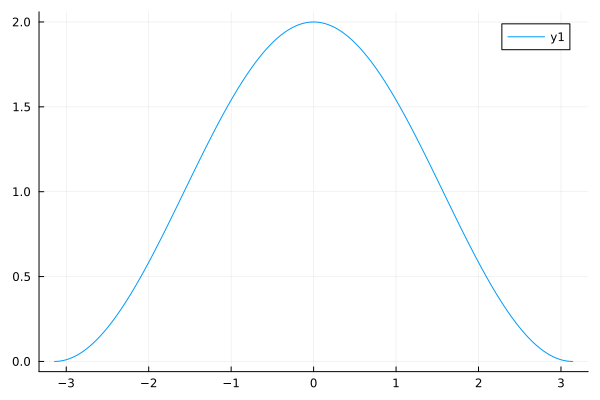

In [14]:
k = 900
b = 0.1

z = range(-pi, pi, length=1000) |> collect

S = 1 .+ cos.(z)

plot(z, S)

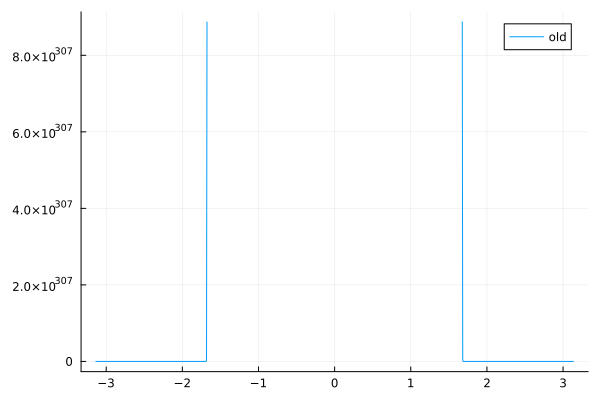

In [17]:
# beta_new = afm_kernel_IK(k, S, b)
beta_old = β_scaled(k, S, b)

plot(z, beta_old, label="old")
# plot(z, beta_new, label="new")